# Spam Message Classifier

**Table of Contents--**<br>
<ol>
    <li>Importing Libraries</li>
    <li>Data Visualization</li>
    <li>Data Preprocessing</li>
    <li>Model Training</li>
    <li>Conclusion</li>
</ol>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


**Importing libraries-->**

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**Dataset reading--->**

In [3]:
df = pd.read_csv('../input/sms-spam-collection-dataset/spam.csv',encoding='latin1')
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
print("Null Values entry in Unnamed:2 column={}\nNull Values entry in Unnamed:3 column={}\nNull Values entry in Unnamed:4 column={}".format(df['Unnamed: 2'].isnull().sum(),df['Unnamed: 3'].isnull().sum(),df['Unnamed: 2'].isnull().sum()))

Null Values entry in Unnamed:2 column=5522
Null Values entry in Unnamed:3 column=5560
Null Values entry in Unnamed:4 column=5522


In [5]:
print("shape of dataset: {}".format(df.shape))

shape of dataset: (5572, 5)


In [6]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [7]:
df.head(10)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [8]:
df.rename(columns={'v1':'Label','v2':'Msg'},inplace=True)

# Data Visualization

total no. of ham msgs: 4825
total no. of spam msgs: 747


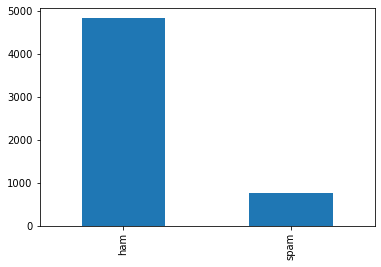

In [9]:
print("total no. of ham msgs: {}\ntotal no. of spam msgs: {}".format(df['Label'].value_counts()[0],df['Label'].value_counts()[1]))
df['Label'].value_counts().plot.bar()

In [10]:
df.describe()

,Label,Msg
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [11]:
df['len']=df['Msg'].apply(len)
df.head()

,Label,Msg,len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Let's see the longest msg  and its label

In [12]:
print("Message={}\n\nLabel={}".format(df['Msg'][df['len'].idxmax()],df['Label'][df['len'].idxmax()]))

Message=For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..

Label=ham


Let's see the shortest msg and its label

In [13]:
print("Message={}\n\nLabel={}".format(df['Msg'][df['len'].idxmin()],df['Label'][df['len'].idxmin()]))

Message=Ok

Label=ham


Text(0.5, 1.0, 'Length Histogram')

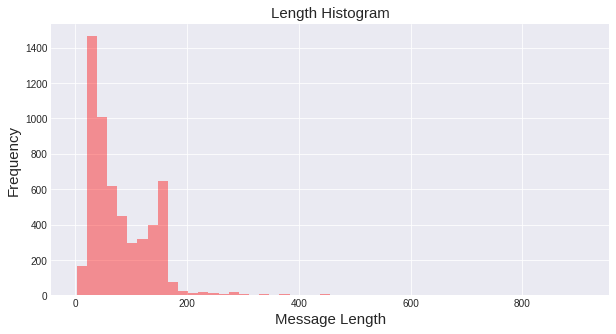

In [14]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,5))
sns.distplot(df['len'],kde=False,color='red',hist=True)
plt.xlabel("Message Length",size=15)
plt.ylabel("Frequency",size=15)
plt.title("Length Histogram",size=15)

Text(0.5, 0, 'Message Length')

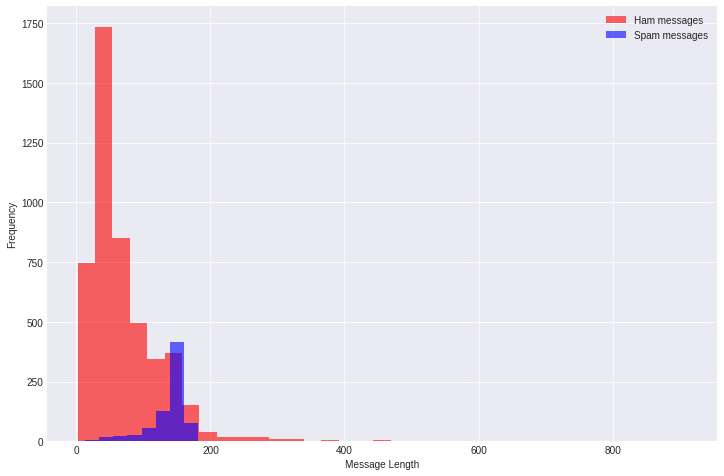

In [15]:
plt.figure(figsize=(12, 8))

df[df['Label']=='ham'].len.plot(bins=35, kind='hist', color='red', 
                                       label='Ham messages', alpha=0.6)
df[df['Label']=='spam'].len.plot(kind='hist', color='blue', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

From this we can see that, spam label messages are of shorter length than ham messages

# Data Preprocessing

In [16]:
import re
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
ps = PorterStemmer() # Using porterstemmer for text preprocessing
message = []
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df['Msg'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    message.append(review)

In [18]:
df['clean_msg']=np.empty((len(message),1))
for i in range(len(message)):
    df['clean_msg'][i]=message[i]
df['clean_msg_len']=df['clean_msg'].apply(len)
df.head()


,Label,Msg,len,clean_msg,clean_msg_len
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazi avail bugi n great world...,76
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,21
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entri wkli comp win fa cup final tkt st m...,99
3,ham,U dun say so early hor... U c already then say...,49,u dun say earli hor u c alreadi say,35
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think goe usf live around though,36


In [19]:
df['Msg'].describe()

count                       5572
unique                      5169
top       Sorry, I'll call later
freq                          30
Name: Msg, dtype: object

In [20]:
df['clean_msg'].describe()

count                 5572
unique                5056
top       sorri call later
freq                    30
Name: clean_msg, dtype: object

In [21]:
df=pd.concat([df, pd.get_dummies(df['Label'])], axis=1)
df.drop(['Label'],axis=1,inplace=True)
df.drop(['spam'],axis=1,inplace=True)
df.rename(columns={'ham':'label'},inplace=True)
df.head()

,Msg,len,clean_msg,clean_msg_len,label
0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazi avail bugi n great world...,76,1
1,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,21,1
2,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entri wkli comp win fa cup final tkt st m...,99,0
3,U dun say so early hor... U c already then say...,49,u dun say earli hor u c alreadi say,35,1
4,"Nah I don't think he goes to usf, he lives aro...",61,nah think goe usf live around though,36,1



**Note**: 1-Ham, 0-Spam

# Vectorization

In [22]:
X=df['clean_msg']
X

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri wkli comp win fa cup final tkt st m...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
                              ...                        
5567    nd time tri contact u u pound prize claim easi...
5568                                b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: clean_msg, Length: 5572, dtype: object

In [23]:
Y=df['label']


**Note: I'm using Countvectorizer for vectorization**

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(message).toarray()
X





array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:
# print(X)
Y=np.array(Y)
type(Y)
# t(Y)

numpy.ndarray

# Model Training

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.10, random_state = 0)


In [27]:
print("X_train shape: {}\n X_test shape: {}\nY_train shape: {}\nY_test shape: {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train shape: (5014, 2500)
 X_test shape: (558, 2500)
Y_train shape: (5014,)
Y_test shape: (558,)


In [28]:
# list for storing accuracy score of different algorithms
acc=[]

**Naive Bayes Classifier**

In [29]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(X_train, y_train)
pred=spam_detect_model.predict(X_test)

print("Accuracy of Naive Bayes Classifier is: {}".format(metrics.accuracy_score(y_test,pred)))
acc.append(metrics.accuracy_score(y_test,pred))

Accuracy of Naive Bayes Classifier is: 0.9802867383512545


**Logistic Regression**

In [30]:
from sklearn.linear_model import LogisticRegression
LR=LogisticRegression(solver='liblinear')
LR.fit(X_train,y_train)
yhat = LR.predict(X_test)
print("LogisticRegression's Accuracy:{0}".format(metrics.accuracy_score(y_test, yhat)))
acc.append(metrics.accuracy_score(y_test,yhat))

LogisticRegression's Accuracy:0.9802867383512545


**SVM**

In [31]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
print("SVM's Accuracy:{0}".format(metrics.accuracy_score(y_test, yhat)))
acc.append(metrics.accuracy_score(y_test, yhat))

SVM's Accuracy:0.9767025089605734


**Random Forest Classifier**

In [32]:
from sklearn.ensemble import RandomForestClassifier
Random_forest = RandomForestClassifier(n_estimators=50)
Random_forest.fit(X_train,y_train)
randomForest_predict = Random_forest.predict(X_test)
randomForest_score = metrics.accuracy_score(y_test, randomForest_predict)
print("Random Forest Score :",randomForest_score)
acc.append(metrics.accuracy_score(y_test,randomForest_predict ))

Random Forest Score : 0.982078853046595


**Gradient Boosting**

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier(random_state=100, n_estimators=150,min_samples_split=100, max_depth=6)
gbk.fit(X_train, y_train)
gbk_predict = gbk.predict(X_test)
print("Gradient Boosting Score :",metrics.accuracy_score(y_test,gbk_predict ))
acc.append(metrics.accuracy_score(y_test,gbk_predict ))

Gradient Boosting Score : 0.9767025089605734


**KNN**

In [34]:
from sklearn.neighbors import KNeighborsClassifier
mx=-1
for i in range(1,25):
    
    neigh=KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    KNN_score=metrics.accuracy_score(y_test, yhat)
    print("KNN Accuracy at {} is {}".format(i,KNN_score))
    mx=max(mx,KNN_score)
    print("\n")
acc.append(mx)
mx

KNN Accuracy at 1 is 0.953405017921147


KNN Accuracy at 2 is 0.9587813620071685


KNN Accuracy at 3 is 0.9265232974910395


KNN Accuracy at 4 is 0.9283154121863799


KNN Accuracy at 5 is 0.9121863799283154


KNN Accuracy at 6 is 0.9175627240143369


KNN Accuracy at 7 is 0.8924731182795699


KNN Accuracy at 8 is 0.8942652329749103


KNN Accuracy at 9 is 0.8870967741935484


KNN Accuracy at 10 is 0.8870967741935484


KNN Accuracy at 11 is 0.8817204301075269


KNN Accuracy at 12 is 0.8817204301075269


KNN Accuracy at 13 is 0.8727598566308243


KNN Accuracy at 14 is 0.8745519713261649


KNN Accuracy at 15 is 0.8727598566308243


KNN Accuracy at 16 is 0.8745519713261649


KNN Accuracy at 17 is 0.8673835125448028


KNN Accuracy at 18 is 0.8673835125448028


KNN Accuracy at 19 is 0.8620071684587813


KNN Accuracy at 20 is 0.8620071684587813


KNN Accuracy at 21 is 0.8620071684587813


KNN Accuracy at 22 is 0.8620071684587813


KNN Accuracy at 23 is 0.8584229390681004


KNN Accuracy at 24 is

0.9587813620071685

# Conclusion

Text(0, 0.5, 'Accuracy')

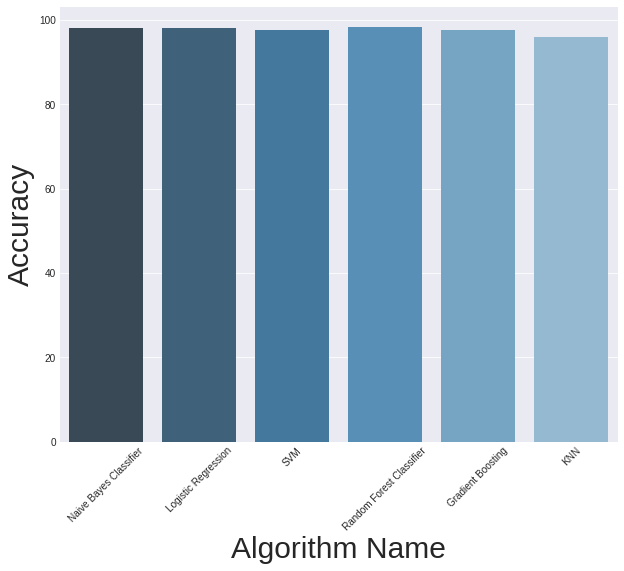

In [35]:
algo_name=['Naive Bayes Classifier','Logistic Regression','SVM','Random Forest Classifier','Gradient Boosting','KNN']
acc=np.array(acc)
from numpy import median
plt.figure(figsize=(10,8))
sns.barplot(y=acc*100,x=algo_name,estimator=median,palette="Blues_d")
plt.xlabel('Algorithm Name',size=30)
plt.xticks(rotation=45)
plt.ylabel('Accuracy',size=30)



# Please Upvote, if you found this notebook helpful.